In [1]:
%reset -f
### One needs to first run https://www.kaggle.com/left13/various-nets-densenet121-0-96-acc-full-set
### DenseNet121 N_FFT 256 - 23 EPOCHS - 0.96 ACC ON 20% TEST
from utils import *
import pickle
import os, math
import numpy as np
seed = 2018
np.random.seed(seed)

import librosa
from collections import Counter
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras import Model
from keras import backend as K
from keras.utils import np_utils
from keras.applications.densenet import DenseNet121

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
Using TensorFlow backend.


In [3]:
current_model = DenseNet121

model_name = TEMP_DATADIR+'wingbeats_190123_' + 'DenseNet121'#current_model#.__name__
print(model_name)

best_weights_path = model_name + '.h5'
valid_features_file = 'valid_features.dat'
valid_labels_file = 'valid_labels.dat'
batch_size = 32

SR = 8000
N_FFT = 256
HOP_LEN = int(N_FFT / 6)
input_shape = (129, 120, 1)

/home/kalfasyan/projects/wingbeat_frequencies/temp_data/wingbeats_190123_DenseNet121


In [4]:
target_names = ['Ae. aegypti', 'Ae. albopictus', 'An. gambiae', 'An. arabiensis', 'C. pipiens', 'C. quinquefasciatus']

X_names = []
y = []
target_count = []

for i, target in enumerate(target_names):
    target_count.append(0)
    path = '/home/kalfasyan/data/insects/Wingbeats/' + target + '/'
    for [root, dirs, files] in os.walk(path, topdown = False):
        for filename in files:
            name,ext = os.path.splitext(filename)
            if ext == '.wav':
                name = os.path.join(root, filename)
                y.append(i)
                X_names.append(name)
                target_count[i]+=1
                # if target_count[i] > 20000:
                #     break
    print (target, '#recs = ', target_count[i])

print ('total #recs = ', len(y))

X_names, y = shuffle(X_names, y, random_state = seed)
X_train, X_test, y_train, y_test = train_test_split(X_names, y, stratify = y, test_size = 0.20, random_state = seed)

print ('train #recs = ', len(X_train))
print ('test #recs = ', len(X_test))

Ae. aegypti #recs =  85553
Ae. albopictus #recs =  20231
An. gambiae #recs =  49471
An. arabiensis #recs =  19297
C. pipiens #recs =  30415
C. quinquefasciatus #recs =  74599
total #recs =  279566
train #recs =  223652
test #recs =  55914


In [5]:
def equal_split(X, y, size):
    equal_split_X_test = []
    equal_split_y_test = []
    classes_count = [0] * len(y)

    for i in range(len(X)):
        if classes_count[y[i]] < size:
            equal_split_X_test.append(X[i])
            equal_split_y_test.append(y[i])

            classes_count[y[i]]+=1

    return equal_split_X_test, equal_split_y_test

In [6]:
X_test, y_test = equal_split(X_test, y_test, min(Counter(y_test).values()))

In [7]:
pickle.dump(X_test, open(TEMP_DATADIR + 'xtest_names.dat', "wb"))
pickle.dump(y_test, open(TEMP_DATADIR + 'ytest_names.dat', "wb"))

In [8]:
def valid_generator():
    while True:
        for start in range(0, len(X_test), batch_size):
            x_batch = []
            y_batch = []
            
            end = min(start + batch_size, len(X_test))
            test_batch = X_test[start:end]
            labels_batch = y_test[start:end]
            
            for i in range(len(test_batch)):
                data, rate = librosa.load(test_batch[i], sr = SR)

                data = librosa.stft(data, n_fft = N_FFT, hop_length = HOP_LEN)
                data = librosa.amplitude_to_db(np.abs(data))

                data = np.flipud(data)

                data = np.expand_dims(data, axis = -1)

                x_batch.append(data)
                y_batch.append(labels_batch[i])

            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            
            y_batch = np_utils.to_categorical(y_batch, len(target_names))
            
            yield x_batch, y_batch

In [17]:
img_input = Input(shape = input_shape)

model = current_model(input_tensor = img_input, classes = len(target_names), weights = None)

x_new = model.layers[-2].output

# Load pretrained weights. You can get them after running the code in the following link https://www.kaggle.com/left13/various-nets-densenet121-0-96-acc-full-set
model.load_weights(best_weights_path)

model = Model(img_input, x_new, name = 'densenet')

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

In [18]:
#model.summary()
#model.layers[-1].get_weights()[0].shape
# model.layers[-1]
# x_new

In [19]:
valid_features = model.predict_generator(
    valid_generator(), int(math.ceil(float(len(X_test)) / float(batch_size))))

In [20]:
pickle.dump(valid_features, open(TEMP_DATADIR + valid_features_file, "wb"))
pickle.dump(y_test, open(TEMP_DATADIR+ valid_labels_file, "wb"))

In [21]:
XX = pickle.load(open(TEMP_DATADIR + valid_features_file, "rb"))
y = pickle.load(open(TEMP_DATADIR + valid_labels_file, "rb"))

In [22]:
tsne = manifold.TSNE(n_components = 2, perplexity = 30, init='pca',random_state = seed, verbose = 1)
X = tsne.fit_transform(np.vstack(XX))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23160 samples in 2.201s...
[t-SNE] Computed neighbors for 23160 samples in 637.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23160
[t-SNE] Computed conditional probabilities for sample 2000 / 23160
[t-SNE] Computed conditional probabilities for sample 3000 / 23160
[t-SNE] Computed conditional probabilities for sample 4000 / 23160
[t-SNE] Computed conditional probabilities for sample 5000 / 23160
[t-SNE] Computed conditional probabilities for sample 6000 / 23160
[t-SNE] Computed conditional probabilities for sample 7000 / 23160
[t-SNE] Computed conditional probabilities for sample 8000 / 23160
[t-SNE] Computed conditional probabilities for sample 9000 / 23160
[t-SNE] Computed conditional probabilities for sample 10000 / 23160
[t-SNE] Computed conditional probabilities for sample 11000 / 23160
[t-SNE] Computed conditional probabilities for sample 12000 / 23160
[t-SNE] Computed conditional probabilities for s

In [23]:
pickle.dump(X, open(TEMP_DATADIR + 'tsne.dat', "wb"))

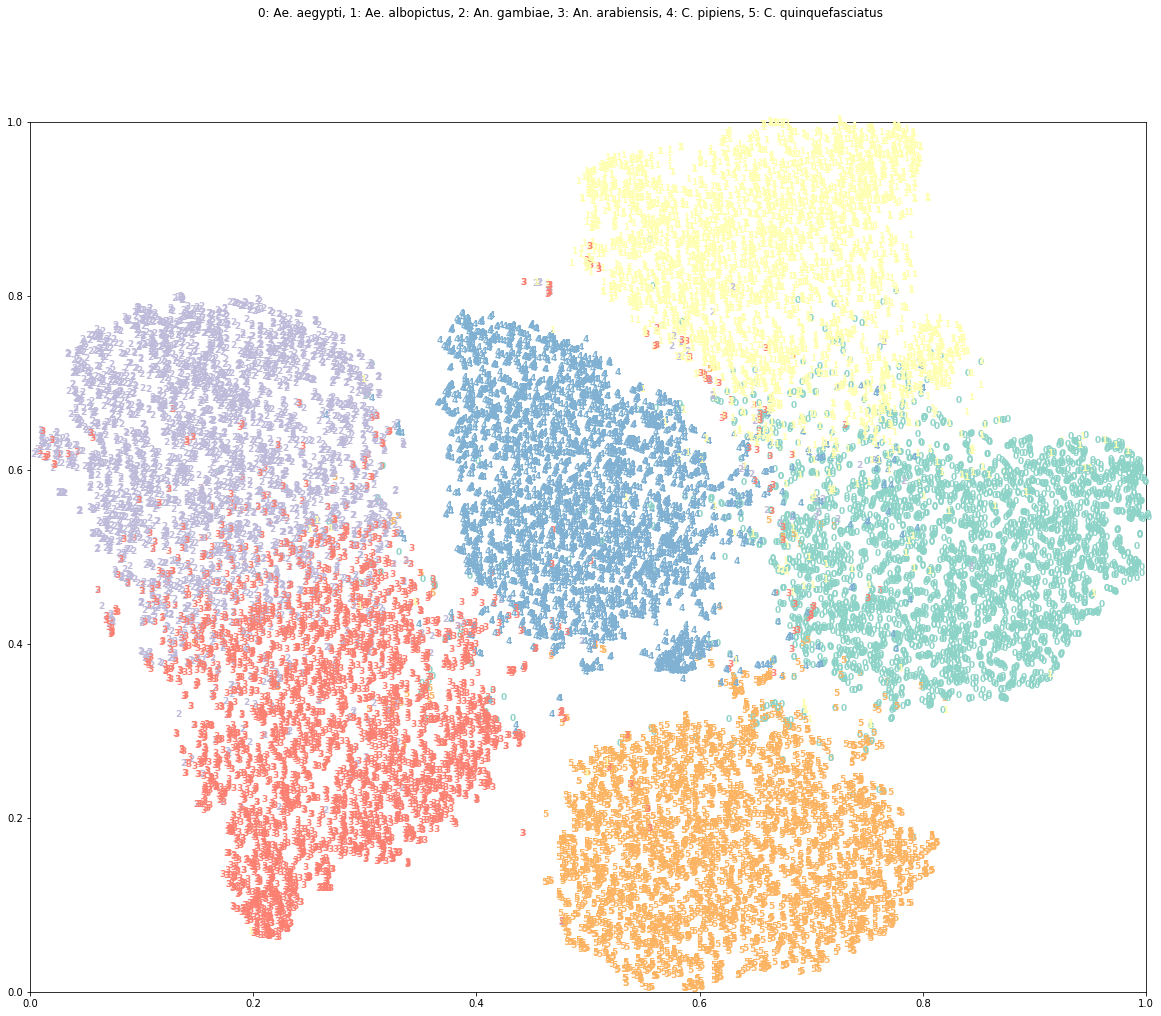

In [24]:
fig = plt.figure(figsize = (2*10, 2*8))
ax = fig.gca()

x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(y[i]), color = plt.cm.Set3(y[i]), fontdict = {'weight': 'bold', 'size': 9})

fig.suptitle('0: Ae. aegypti, 1: Ae. albopictus, 2: An. gambiae, 3: An. arabiensis, 4: C. pipiens, 5: C. quinquefasciatus')

plt.show()

In [25]:
len(y_test)

23160

In [27]:
y_me = np.random.randint(0,np.max(y_test), size=len(y_test))